In [123]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [124]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import date
from dateutil.relativedelta import relativedelta
from flask import Flask, jsonify

# Reflect Tables into SQLAlchemy ORM

In [104]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import desc

In [19]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [20]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [21]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [22]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [23]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [24]:
for row in session.query(Measurement, Measurement.date).limit(5).all():
    print(row)

(<sqlalchemy.ext.automap.measurement object at 0x00000000092DB4A8>, '2010-01-01')
(<sqlalchemy.ext.automap.measurement object at 0x00000000092DBAC8>, '2010-01-02')
(<sqlalchemy.ext.automap.measurement object at 0x00000000092DBB38>, '2010-01-03')
(<sqlalchemy.ext.automap.measurement object at 0x00000000092DBBA8>, '2010-01-04')
(<sqlalchemy.ext.automap.measurement object at 0x00000000092DBC18>, '2010-01-06')


# Part One: Exploratory & Climate Analysis

# Precipitation Analysis

In [25]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

test_data = session.query(Measurement).filter(Measurement.date == '2010-01-01').all()
for prcp in test_data:
    print("Date: {0}, Precipitation: {1}".format(prcp.date, prcp.prcp))


Date: 2010-01-01, Precipitation: 0.08
Date: 2010-01-01, Precipitation: 0.28
Date: 2010-01-01, Precipitation: 0.21
Date: 2010-01-01, Precipitation: 0.15
Date: 2010-01-01, Precipitation: 0.15
Date: 2010-01-01, Precipitation: 0.05
Date: 2010-01-01, Precipitation: 0.14


In [39]:
# Earliest date
earliest_date = session.query(func.min(Measurement.date)).first()
earliest_date

('2010-01-01')

In [42]:
# Latest date
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first().date
latest_date

'2017-08-23'

In [44]:
# 12 months from Latest date
last_twelve_months = dt.datetime.strptime(latest_date, '%Y-%m-%d') - relativedelta(months=+12)
last_twelve_months

datetime.datetime(2016, 8, 23, 0, 0)

In [47]:
prev_year_data = session.query(Measurement.date, func.avg(Measurement.prcp)).\
                    filter(Measurement.date >= last_twelve_months).\
                    group_by(Measurement.date).all()
prev_year_data

[('2016-08-24', 1.5549999999999997),
 ('2016-08-25', 0.07714285714285715),
 ('2016-08-26', 0.016666666666666666),
 ('2016-08-27', 0.06399999999999999),
 ('2016-08-28', 0.5166666666666666),
 ('2016-08-29', 0.24333333333333332),
 ('2016-08-30', 0.011666666666666667),
 ('2016-08-31', 0.6359999999999999),
 ('2016-09-01', 0.006),
 ('2016-09-02', 0.05),
 ('2016-09-03', 0.254),
 ('2016-09-04', 0.276),
 ('2016-09-05', 0.08499999999999999),
 ('2016-09-06', 0.246),
 ('2016-09-07', 0.3333333333333333),
 ('2016-09-08', 0.07666666666666667),
 ('2016-09-09', 0.17833333333333332),
 ('2016-09-10', 0.27999999999999997),
 ('2016-09-11', 0.25),
 ('2016-09-12', 0.308),
 ('2016-09-13', 0.45166666666666666),
 ('2016-09-14', 2.3800000000000003),
 ('2016-09-15', 0.8266666666666667),
 ('2016-09-16', 0.11714285714285715),
 ('2016-09-17', 0.13599999999999998),
 ('2016-09-18', 0.10600000000000001),
 ('2016-09-19', 0.064),
 ('2016-09-20', 0.14714285714285716),
 ('2016-09-21', 0.19499999999999998),
 ('2016-09-22', 

In [56]:
# Load the query results into a Pandas DataFrame and set the index to the date column.
# Sort the DataFrame values by `date`.
df_sorted = pd.DataFrame(prev_year_data, columns=['Date', 'Precipitation']).sort_values(by="Date",ascending=False)
df_sorted.set_index("Date", inplace=True)
df_sorted.head()

,Precipitation
Date,
2017-08-23,0.132500
2017-08-22,0.166667
2017-08-21,0.193333
2017-08-20,0.005000
2017-08-19,0.030000


<function matplotlib.pyplot.show(*args, **kw)>

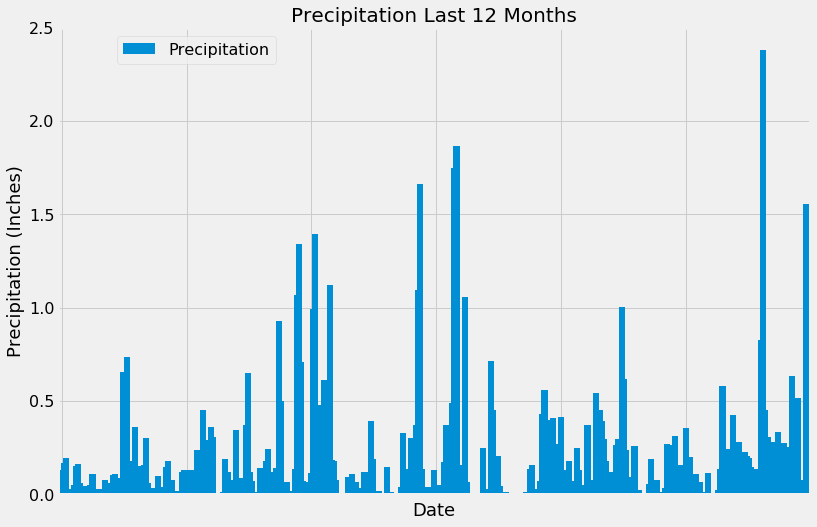

In [57]:
# Plot the results using the DataFrame `plot` method.

ax = df_sorted.plot(kind='bar', width=3, figsize=(12,8))
plt.locator_params(axis='x', nbins=6)
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.tick_params(axis='y', labelsize=16)
ax.grid(True)
plt.legend(bbox_to_anchor=(.3,1), fontsize="16")
plt.title("Precipitation Last 12 Months", size=20)
plt.ylabel("Precipitation (Inches)", size=18)
plt.xlabel("Date", size=18)
plt.savefig("Prcp vs. Date.png")
plt.show

In [59]:
# * Use Pandas to print the summary statistics for the precipitation data.
df_sorted.describe()

,Precipitation
count,365.000000
mean,0.169987
std,0.295722
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


# Station Analysis

In [61]:
# * Design a query to calculate the total number of stations.
stations = session.query(Station.station).count()
stations

9

In [103]:
# * Design a query to find the most active stations.
#   * List the stations and observation counts in descending order.
#   * Which station has the highest number of observations?

activity_stations = session.query(Measurement.station, func.count(Measurement.station)).\
                    group_by(Measurement.station).\
                    order_by(func.count(Measurement.station).desc()).all()
activity_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [114]:
# * Design a query to retrieve the last 12 months of temperature observation data (tobs).
#   * Filter by the station with the highest number of observations.
best_station = activity_stations[0][0]
annual_temp_data = session.query(Measurement.station, Measurement.tobs).\
                    filter(Measurement.date >= last_twelve_months, Measurement.station == best_station).\
                    group_by(Measurement.date).all()
annual_temp_data

[('USC00519281', 77.0),
 ('USC00519281', 80.0),
 ('USC00519281', 80.0),
 ('USC00519281', 75.0),
 ('USC00519281', 73.0),
 ('USC00519281', 78.0),
 ('USC00519281', 77.0),
 ('USC00519281', 78.0),
 ('USC00519281', 80.0),
 ('USC00519281', 80.0),
 ('USC00519281', 78.0),
 ('USC00519281', 78.0),
 ('USC00519281', 78.0),
 ('USC00519281', 73.0),
 ('USC00519281', 74.0),
 ('USC00519281', 80.0),
 ('USC00519281', 79.0),
 ('USC00519281', 77.0),
 ('USC00519281', 80.0),
 ('USC00519281', 76.0),
 ('USC00519281', 79.0),
 ('USC00519281', 75.0),
 ('USC00519281', 79.0),
 ('USC00519281', 78.0),
 ('USC00519281', 79.0),
 ('USC00519281', 78.0),
 ('USC00519281', 78.0),
 ('USC00519281', 76.0),
 ('USC00519281', 74.0),
 ('USC00519281', 77.0),
 ('USC00519281', 78.0),
 ('USC00519281', 79.0),
 ('USC00519281', 79.0),
 ('USC00519281', 77.0),
 ('USC00519281', 80.0),
 ('USC00519281', 78.0),
 ('USC00519281', 78.0),
 ('USC00519281', 78.0),
 ('USC00519281', 77.0),
 ('USC00519281', 79.0),
 ('USC00519281', 79.0),
 ('USC00519281',

In [116]:
temp_df = pd.DataFrame(annual_temp_data, columns=['station', 'Temperature'])
temp_df.head()

,station,Temperature
0,USC00519281,77.0
1,USC00519281,80.0
2,USC00519281,80.0
3,USC00519281,75.0
4,USC00519281,73.0


<function matplotlib.pyplot.show(*args, **kw)>

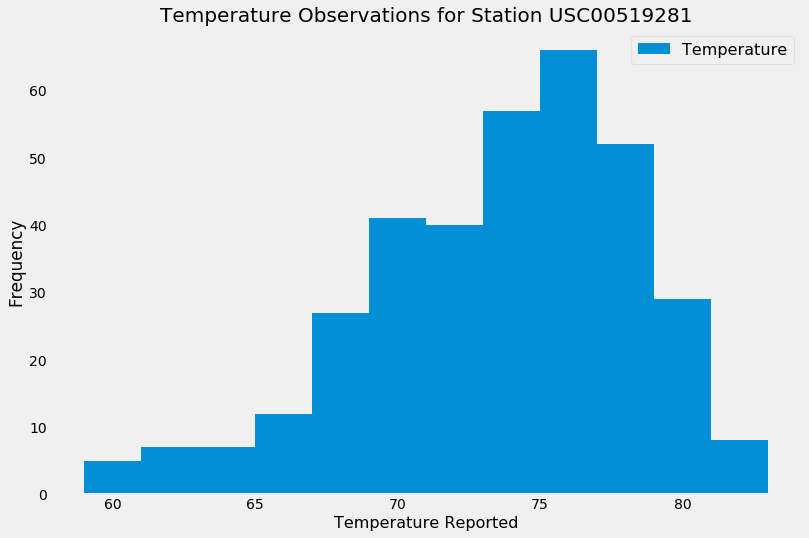

In [117]:
#   * Plot the results as a histogram with `bins=12`.
temp_df.plot.hist(by='station', bins=12, figsize=(12,8))
plt.grid()
plt.title("Temperature Observations for Station " + best_station, fontsize=20)
plt.xlabel("Temperature Reported", fontsize=16)
plt.legend(bbox_to_anchor=(1,1), fontsize=16)
plt.savefig("Station vs. Temps.png")
plt.show

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?


[(54.0, 85.0, 71.66378066378067)]

[('USC00519397',
  '2010-01-01',
  0.08,
  65.0,
  'USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0),
 ('USC00519397',
  '2010-01-02',
  0.0,
  63.0,
  'USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0),
 ('USC00519397',
  '2010-01-03',
  0.0,
  74.0,
  'USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0),
 ('USC00519397',
  '2010-01-04',
  0.0,
  76.0,
  'USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0),
 ('USC00519397',
  '2010-01-06',
  None,
  73.0,
  'USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0),
 ('USC00519397',
  '2010-01-07',
  0.06,
  70.0,
  'USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0),
 ('USC00519397',
  '2010-01-08',
  0.0,
  64.0,
  'USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0),
 ('USC00519397',
  '2010-01-09',
  0.0,
  68.0,
  'USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0),
 ('USC0051939

In [ ]:
# Now that you have completed your initial analysis, design a Flask API based on the queries that you have just developed.

# * Use FLASK to create your routes.

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


62.0 68.36585365853658 74.0


<IPython.core.display.Javascript object>


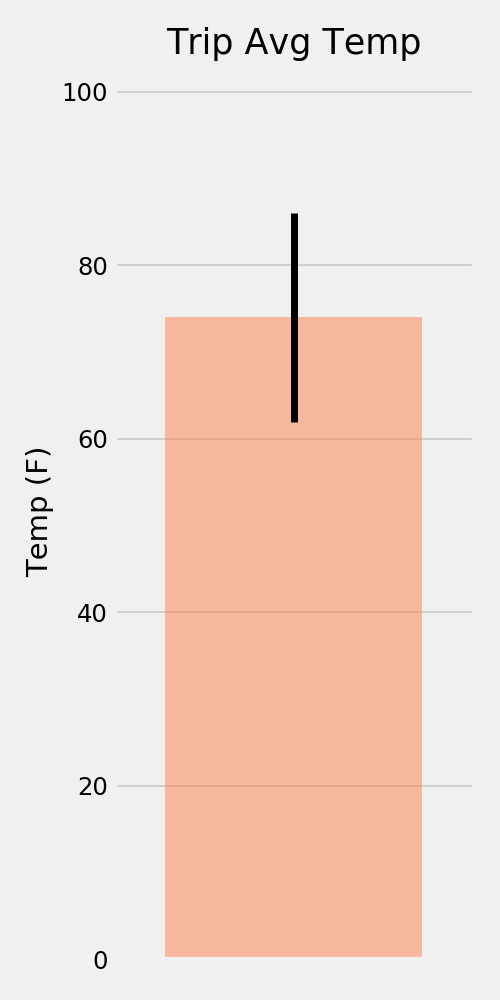

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [19]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.31), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.25), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.1), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.060000000000000005), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)]


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


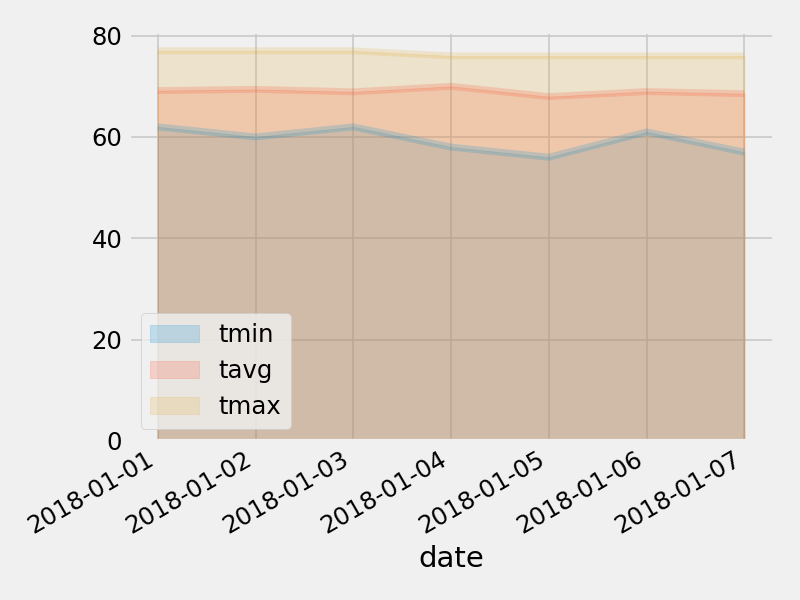

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
